In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pyscf.scf import hf

import matplotlib as mpl
mpl.style.use("seaborn")
ticker = mpl.ticker

from SCFInitialGuess.utilities.analysis import density_cut, matrix_error

export_folder = "/home/jo/Repos/cc2aiPoster/densities/"


In [6]:
from SCFInitialGuess.utilities.dataset import make_butadien_dataset

folder = "../ethen/"

#index = np.load(folder + "index_ethan_6-31g**.npy")
molecules = np.load(folder + "molecules_ethen_6-31g**.npy")
#S = np.load(folder + "S_ethan_6-31g**.npy")
#P = np.load(folder + "P_ethan_6-31g**.npy")
S, P = np.load(folder + "dataset_ethen_6-31g**.npy")


dataset, molecules = make_butadien_dataset(
    molecules, 
    S,
    P,
    test_samples=100
)


[-] 2018-06-02 20:16:03: Data set normalized. Mean value std: 0.01556117276124646


## Pick a sample from the dataset. 
*make sure it is in the test dataset part and close to the
start of the md run!*

In [7]:
list(molecules[1][0].geometry)

[('C', [-2.7085926267, 2.5159148733, -0.0393244522]),
 ('C', [-1.4413878805, 2.4121980536, 0.0382945524]),
 ('H', [-3.1444774443, 3.3070595883, 0.4049164556]),
 ('H', [-3.2559182595, 1.8235471376, -0.5133957583]),
 ('H', [-0.8699189975, 3.0920704208, 0.5337558656]),
 ('H', [-1.0105869843, 1.6187668277, -0.4130137822])]

In [8]:
#sample_index = list(index).index(0)
#dim = 26


#mole = molecules[index].get_pyscf_molecule()
#s = S[sample_index].reshape(dim, dim)
#p = P[sample_index].reshape(dim, dim)
#mole = (molecules[0] + molecules[1])[sample_index].get_pyscf_molecule()

#sample_index

In [9]:
z_value = 4
nx = 80
ny = 80

norm = None#plt.Normalize(0, 7.6e-5)

In [10]:
from pyscf.gto import Mole

# this molecule was not in dateset!!!
#mole = molecules[1][0].get_pyscf_molecule()
mole = Mole()
mole.atom = molecules[1][0].geometry

mole.basis = "6-31g**"
mole.build()

In [11]:
coords = mole.atom_coords()[:, 2]
np.mean(coords), np.std(coords)

(0.00353784474847633, 0.7261730520982445)

# Converged 

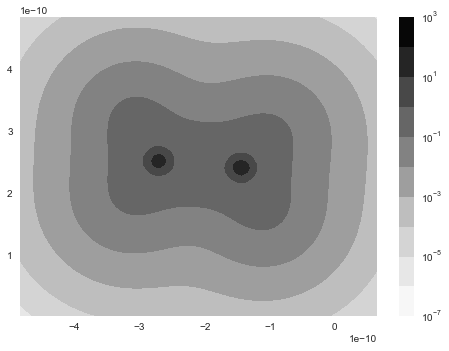

In [12]:
mf = hf.RHF(mole)
mf.verbose = 1
mf.run()

dm = mf.make_rdm1()
dm_density, x, y = density_cut(mole, dm, nx, ny, z_value=z_value)

plt.contourf(*np.meshgrid(x, y), dm_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

# H_core

In [13]:
dm_1e = hf.init_guess_by_1e(mole)
dm_1e_density, x, y = density_cut(mole, dm_1e, nx, ny, z_value=z_value)

In [14]:
np.max(dm_1e_density), np.min(dm_1e_density)


(72.52907807951297, 2.304257390753451e-06)

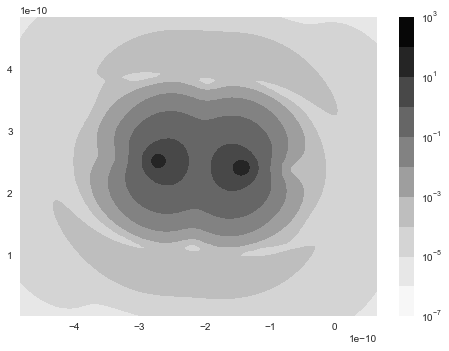

In [15]:
plt.contourf(*np.meshgrid(x, y), dm_1e_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

In [16]:
"""
for z in np.linspace(-1,5, 20):    
    dm_1e = hf.init_guess_by_1e(mole)
    dm_1e_density, x, y = density_cut(mole, dm_1e, nx, ny, z_value=z)
    plt.figure()
    plt.contourf(*np.meshgrid(x, y), dm_1e_density, locator=ticker.LogLocator())
    plt.colorbar()
    plt.title("z = " + str(z))
plt.show()
"""

'\nfor z in np.linspace(-1,5, 20):    \n    dm_1e = hf.init_guess_by_1e(mole)\n    dm_1e_density, x, y = density_cut(mole, dm_1e, nx, ny, z_value=z)\n    plt.figure()\n    plt.contourf(*np.meshgrid(x, y), dm_1e_density, locator=ticker.LogLocator())\n    plt.colorbar()\n    plt.title("z = " + str(z))\nplt.show()\n'

# SAP

In [17]:
dm_sap = hf.init_guess_by_atom(mole)
dm_sap_density, x, y = density_cut(mole, dm_sap, nx, ny, z_value)

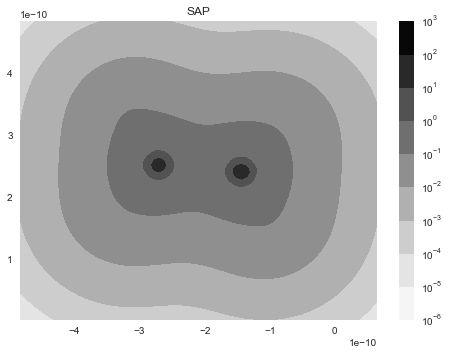

In [18]:
plt.contourf(*np.meshgrid(x, y), dm_sap_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.title("SAP")
plt.show()

# GWH

In [19]:
dm_gwh = hf.init_guess_by_wolfsberg_helmholtz(mole)
dm_gwh_density, x, y = density_cut(mole, dm_gwh, nx, ny, z_value)

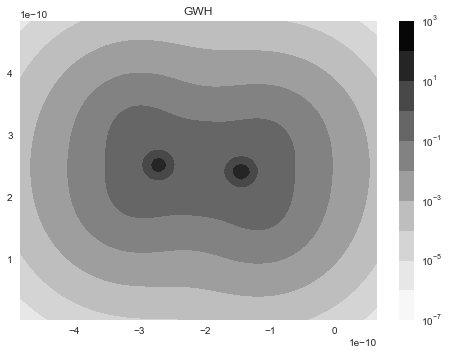

In [20]:
plt.contourf(*np.meshgrid(x, y), dm_gwh_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.title("GWH")
plt.show()

# MINAO

In [21]:
dm_minao = hf.init_guess_by_minao(mole)
dm_minao_density, x, y = density_cut(mole, dm_minao, nx, ny, z_value)

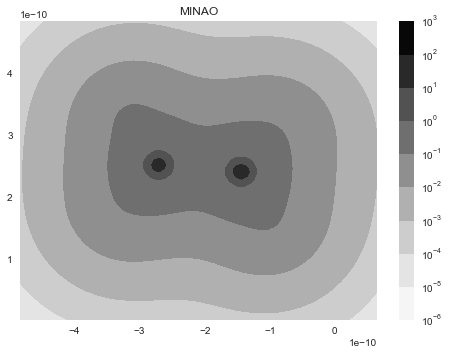

In [22]:
plt.contourf(*np.meshgrid(x, y), dm_minao_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.title("MINAO")
plt.show()

# NN

In [26]:
import tensorflow as tf
from SCFInitialGuess.nn.networks import EluFixedValue

graph = tf.Graph()

structure, weights, biases = np.load("../ethen/network_ethen.npy", encoding="latin1")

with graph.as_default():
    sess = tf.Session()
    network = EluFixedValue(structure, weights, biases)
    network.setup()
    sess.run(tf.global_variables_initializer())

In [27]:
from SCFInitialGuess.utilities.dataset import extract_triu
dim = 48
s = hf.get_ovlp(mole)
s_norm = dataset.input_transformation(s.reshape(-1, dim**2))
s_norm = extract_triu(s_norm, dim).reshape(-1, int(dim * (dim +1 )/ 2))
s_norm.shape

(1, 1176)

In [28]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny
from SCFInitialGuess.utilities.dataset import reconstruct_from_triu

dm_nn = network.run(sess, s_norm)
dm_nn = reconstruct_from_triu(dm_nn, dim).reshape(dim, dim).astype("float64")
dm_nn_density, x, y = density_cut(mole, dm_nn, nx, ny, z_value) 

In [29]:
from SCFInitialGuess.utilities.analysis import measure_idempotence_error, measure_absolute_error

print(list(measure_idempotence_error([dm_nn], [s])))

print(np.mean(np.abs(dm - dm_nn)))


[0.015133127737796083]
0.011091571657368874


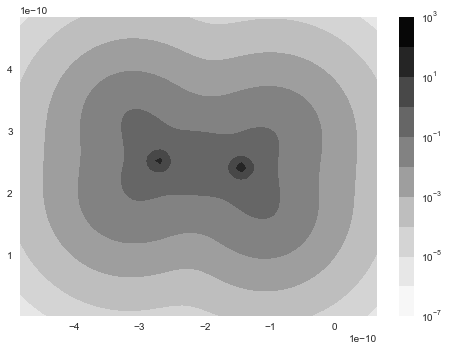

In [30]:
plt.contourf(*np.meshgrid(x, y), dm_nn_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

In [31]:
from SCFInitialGuess.nn.post_processing import multi_mc_wheeny

dm_mcw5 = multi_mc_wheeny(dm_nn, s, 5)
dm_mcw5_density, x, y = density_cut(mole, dm_mcw5, nx, ny, z_value) 

print(list(measure_idempotence_error([dm_mcw5], [s])))

[0.0052111288299391744]


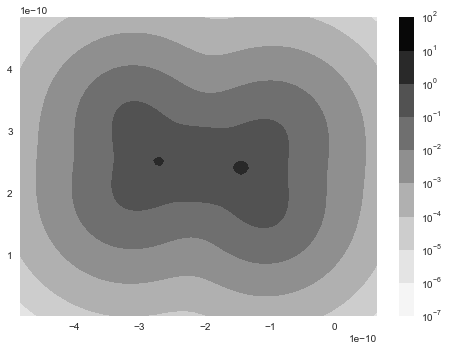

In [32]:
plt.contourf(*np.meshgrid(x, y), dm_mcw5_density, locator=ticker.LogLocator(), norm=norm)
plt.colorbar()
plt.show()

# Subplot

## Absolute

In [33]:
vmin = 1e-11
vmax = 1e5

ylabel = r"y / $\AA$"
xlabel = r"x / $\AA$"

x *= 1e10
y *= 1e10

norm = plt.Normalize(vmin, vmax)

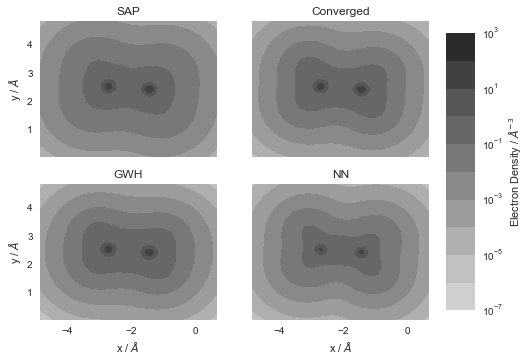

In [34]:
fig, axes = plt.subplots(2, 2)

axes[0,0].contourf(*np.meshgrid(x, y), dm_sap_density, locator=ticker.LogLocator(), vmin=vmin, vmax=vmax)
axes[0,0].set_title("SAP")
axes[0,0].ticklabel_format(style='plain', axis='x')
axes[0,0].set_ylabel(ylabel)



axes[1,0].contourf(*np.meshgrid(x, y), dm_gwh_density, locator=ticker.LogLocator(), vmin=vmin, vmax=vmax)
axes[1,0].set_title("GWH")
axes[1,0].set_xlabel(xlabel)
axes[1,0].set_ylabel(ylabel)

axes[0,1].contourf(*np.meshgrid(x, y), dm_density, locator=ticker.LogLocator(), vmin=vmin, vmax=vmax)
axes[0,1].set_title("Converged")
axes[0,1].ticklabel_format(style='plain')


im = axes[1,1].contourf(*np.meshgrid(x, y), dm_nn_density, locator=ticker.LogLocator(),  vmin=vmin, vmax=vmax)
axes[1,1].set_title("NN")
axes[1,1].ticklabel_format(style='plain', axis='y')
axes[1,1].set_xlabel(xlabel)

_ = plt.setp([a.get_xticklabels() for a in axes[0, :]], visible=False)
_ = plt.setp([a.get_yticklabels() for a in axes[:, 1]], visible=False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
#cbar.ax.text(.5, (2 * j + 1) / 8.0, lab, ha='center', va='center')
cbar.set_label(r"Electron Density / $\AA^{-3}$")

plt.savefig(export_folder + "density_cuts.pdf")
#

## Difference 

In [57]:
vmin = 1e-10
vmax = 1e2

ylabel = r"y / $\AA$"
xlabel = r"x / $\AA$"

x *= 1e10
y *= 1e10

norm = plt.Normalize(vmin, vmax)

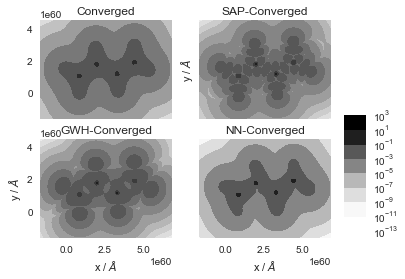

In [62]:
fig, axes = plt.subplots(2, 2)

axes[0,0].contourf(*np.meshgrid(x, y), dm_density, locator=ticker.LogLocator())
axes[0,0].set_title("Converged")
axes[0,0].ticklabel_format(style='plain', axis='x')
axes[0,1].set_ylabel(ylabel)

axes[0,1].contourf(*np.meshgrid(x, y), abs(dm_sap_density-dm_density), locator=ticker.LogLocator(), vmin=vmin, vmax=vmax)
axes[0,1].set_title("SAP-Converged")
axes[0,1].ticklabel_format(style='plain')

axes[1,0].contourf(*np.meshgrid(x, y), abs(dm_gwh_density-dm_density), locator=ticker.LogLocator(), vmin=vmin, vmax=vmax)
axes[1,0].set_title("GWH-Converged")
axes[1,0].set_xlabel(xlabel)
axes[1,0].set_ylabel(ylabel)


im = axes[1,1].contourf(*np.meshgrid(x, y), abs(dm_nn_density-dm_density), locator=ticker.LogLocator(),  vmin=vmin, vmax=vmax)
axes[1,1].set_title("NN-Converged")
axes[1,1].ticklabel_format(style='plain', axis='y')
axes[1,1].set_xlabel(xlabel)

_ = plt.setp([a.get_xticklabels() for a in axes[0, :]], visible=False)
_ = plt.setp([a.get_yticklabels() for a in axes[:, 1]], visible=False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.83, 0.15, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cbar_ax)
#cbar.ax.text(.5, (2 * j + 1) / 8.0, lab, ha='center', va='center')
#cbar.set_label(r"Electron Density / $\AA^{-3}$")

#plt.savefig(export_folder + "density_cuts.pdf")